
# Denoising Autoencoder

In this notebook, you will implement a denoising autoencoder using convolutional layers that will be capable of denoising the MNIST digits.

In [3]:
import torch
import numpy as np
from torchvision import datasets
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from visualize_util import visualize_img_batch

In [4]:
# Use this if you are using any Cuda enabled system
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Load MNIST Dataset 

In [5]:
# TODO:convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
mnist_train = datasets.MNIST('./data', train=True,
                                   download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False,
                                  download=True, transform=transform)

#TODO
n_epochs = 20
batch_size = 50

# prepare data loaders
loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2)
loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, num_workers=2)

### Visualize the Data

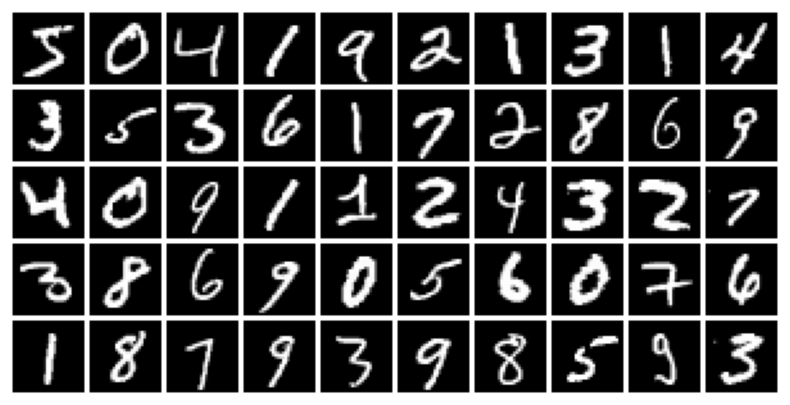

In [6]:
imgs = next(iter(loader_train))[0].numpy().squeeze()
visualize_img_batch(imgs)

In [7]:
class DenoiseAE(nn.Module):
    def __init__(self):
        super(DenoiseAE, self).__init__()
        #TODO
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16,16,kernel_size=3),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16,32,kernel_size=3),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),

        )
        
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(32,16,kernel_size=3,stride=3),
            # nn.BatchNorm2d(16),
            # nn.LeakyReLU(),
            nn.ConvTranspose2d(32,16,kernel_size=2,stride=3),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16,16,kernel_size=4,stride=3),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16,1,kernel_size=4,stride=4),
            nn.Sigmoid()
        )

    def forward(self,x):
        encoder_output= self.encoder(x)
        decoder_output= self.decoder(encoder_output)
        return decoder_output
        # return encoder_output

In [8]:
from torchsummary import summary
denoise_autoencoder = DenoiseAE().to(device)
summary(denoise_autoencoder,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
         LeakyReLU-3           [-1, 16, 26, 26]               0
         MaxPool2d-4           [-1, 16, 13, 13]               0
            Conv2d-5           [-1, 16, 11, 11]           2,320
       BatchNorm2d-6           [-1, 16, 11, 11]              32
         LeakyReLU-7           [-1, 16, 11, 11]               0
         MaxPool2d-8             [-1, 16, 5, 5]               0
            Conv2d-9             [-1, 32, 3, 3]           4,640
      BatchNorm2d-10             [-1, 32, 3, 3]              64
        LeakyReLU-11             [-1, 32, 3, 3]               0
        MaxPool2d-12             [-1, 32, 1, 1]               0
  ConvTranspose2d-13             [-1, 16, 2, 2]           2,064
      BatchNorm2d-14             [-1, 1

---
## Training


In [9]:
criterion = nn.MSELoss() # TODO: specify loss function
optimizer = torch.optim.Adam(denoise_autoencoder.parameters(),lr=0.01) # TODO: specify optimizer

noise_factor=0.5
loss_history=[]
for epoch in range(n_epochs):
    train_loss = 0.0
    #TODO
    for images, _ in loader_train:   
        # add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = torch.clip(noisy_imgs, 0., 1.)
        optimizer.zero_grad()# Use the noisy images during the forward pass
        out=denoise_autoencoder(noisy_imgs)
        l=criterion(out,images)# calculate the loss between the original (not-noisy) and the predicted
        l.backward()# Backward pass         
        optimizer.step()# update running training loss
        train_loss+=l
    # print avg training statistics 
    train_loss = train_loss/len(loader_train)
    loss_history.append(train_loss.item())
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 0.038422
Epoch: 1 	Training Loss: 0.027890
Epoch: 2 	Training Loss: 0.026179
Epoch: 3 	Training Loss: 0.025282
Epoch: 4 	Training Loss: 0.024685
Epoch: 5 	Training Loss: 0.024205
Epoch: 6 	Training Loss: 0.023865
Epoch: 7 	Training Loss: 0.023601
Epoch: 8 	Training Loss: 0.023369
Epoch: 9 	Training Loss: 0.023173
Epoch: 10 	Training Loss: 0.023019
Epoch: 11 	Training Loss: 0.022883
Epoch: 12 	Training Loss: 0.022754
Epoch: 13 	Training Loss: 0.022666
Epoch: 14 	Training Loss: 0.022564
Epoch: 15 	Training Loss: 0.022423
Epoch: 16 	Training Loss: 0.022344
Epoch: 17 	Training Loss: 0.022296
Epoch: 18 	Training Loss: 0.022222
Epoch: 19 	Training Loss: 0.022153


## Results


noisy images:


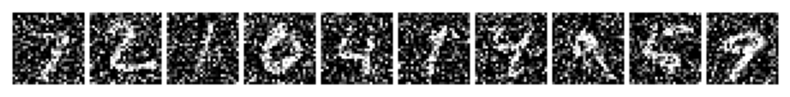

denoised images:


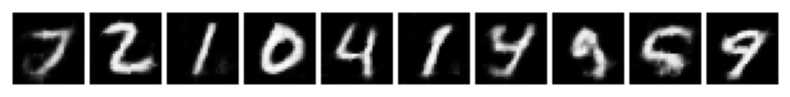

In [10]:
images = next(iter(loader_test))[0][0:10,:,:,:] # assume batch size >10

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = torch.clip(noisy_imgs, 0., 1.)

# show noisy images
print('noisy images:')
visualize_img_batch(noisy_imgs.numpy().squeeze())
plt.show()

# get sample outputs
output = denoise_autoencoder(noisy_imgs.to(device))

# show denoised images
print('denoised images:')
visualize_img_batch(output.detach().cpu().numpy().squeeze())
plt.show()

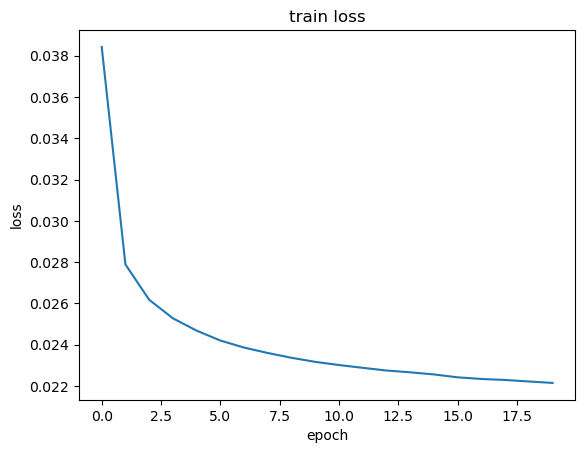

In [11]:
plt.plot(loss_history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('train loss')
plt.show()